# Learning the barrier gate compensation

The idea is to use a markov jump process to directly measure the jump rates instead of fitting models to the transition curve.

## Model

We will model a continuous markov jump process affected by a square pulse. The pulse changes side of a transition with jump frequency $1/\tau$ (i.e., the square pulse has frequency $f=1/(2\tau)$. In our code we model this simplified by saying that the pulse has values $x_t \in \{0,1\}$. Assuming infinitely fast transition speeds, we assume that the electron configuration state follows, i.e., $s_t = \langle x_t \vert$. We model the finite transition speed using a continuous time markov chain with jump rate r. Assuming we let this chain run for infinite time, its distribution will approach the stable distribution of the markov chain. Let $t$ describe the time since the last pulse side change. Then we have 

$P(s_t=x_t|t)=1-(1-\alpha)\exp(-rt)$

where $\alpha$ is the error rate, i.e., that we did start in the target state at time t=0, so no jump was necessary. The stable distribution has $\alpha=\frac 1 {1+\exp(r\tau)}$. One can verify that for this choice of alpha holds 

$P(s_t=x_t|\tau)=1-(1-\alpha)\exp(-r\tau)=1-\frac {\exp(-r\tau)} {1+\exp(-r\tau)}=1-\frac 1{1+\exp(r\tau)}=1-\alpha$

This means that under the assumption that we started in the wrong state with probability $\alpha$ we up in the wrong state with probability $\alpha$ when the pulse switches the next time.

Our simulated signal works the following:

assuming we are in state $s_t$, the sensor sensor signal wilm produce signal $I(s_t)\sim \mathcal{N}(\mu_{s_t},\sigma^2)$ and then we perform time-integration. Again, starting at time of the last pulse jump, $t=0$ we have, for a sample from a stable distribution that the momentary measurement has the mean

$E[I_t]=P(s_t=x_t|\tau)I(s_t)+(1-P(s_t=x_t|\tau))I(1-s_t)$

So, the momentary signal follows the distribution $I_t\sim{} \mathcal{N}(E[I_t],\sigma^2)$. Finally, time integration of the probability leads to

$\int_0^\tau P(s_t=x_t|t) dt = 1-\frac 1 r (1-\alpha)(1-\exp(-r\tau)=1-\frac 1 r  \frac{1-\exp(-r\tau)}{1+\exp(r\tau)}$

Based on this, we can measure the expectations on each side of the pulse and fit the model to it.

## Simulator


In [370]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from numpy.random import exponential as exponential_dist

def simulation(freq, r, num_pulses, N_per_side, means, variances):
    N_meas = 2*num_pulses*N_per_side
    pulse = np.zeros((num_pulses,2,N_per_side))
    T=num_pulses/freq
    xs = np.linspace(0,T,N_meas+1)[:-1]
    pulse[:,1,:]=1
    pulse = pulse.flatten()

    state=np.zeros(N_meas,dtype=int)
    T_per_point = T/N_meas
    cur_state = 1
    for i in range(0,N_meas):
        if (i//N_per_side) % 2 == (1-cur_state):
            
            sample = exponential_dist(scale=1/r)
            #print(sample, T_per_point)
            if sample < T_per_point:
                cur_state = 1-cur_state    
        state[i]=cur_state

    stds = np.sqrt(variances)
    obs_means = means[state]
    obs_std = stds[state]
    observations = obs_means+obs_std*np.random.randn(N_meas)
    
    return pulse, observations, T_per_point*N_per_side, state
means = np.array([0.0,1.0])
variances = 0.1*np.ones(2)
r=100
num_freqs = 50
freqs = np.logspace(np.log10(0.5),2,num_freqs)
pulses=[]
observations=[]
states=[]
T_per_sides=[]
T=10
num_meas = 10000
for freq in freqs:
    num_pulses = int(T*freq)
    meas_per_side = (num_meas//num_pulses)//2
    pulse,obs, T_per_side, state = simulation(freq,r,num_pulses, meas_per_side,means, variances)
    T_per_sides.append(T_per_side)
    pulses.append(pulse)
    observations.append(obs)
    states.append(state)
T_per_sides = np.array(T_per_sides)

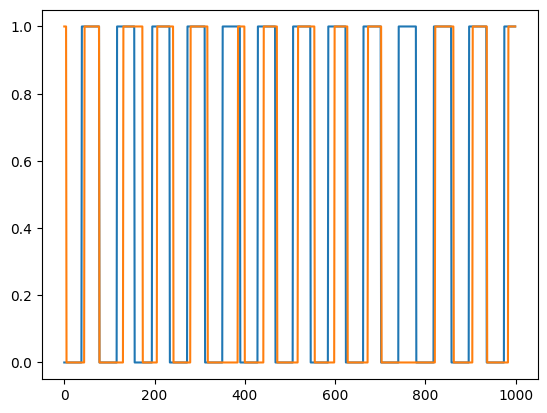

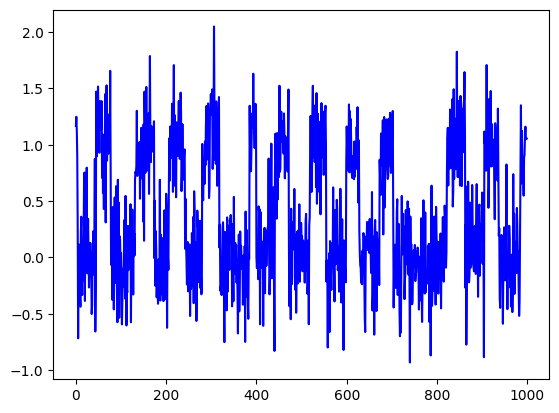

In [372]:
k=30
plt.plot(pulses[k][:1000])
plt.plot(states[k][:1000])
plt.show()
plt.plot(observations[k][:1000],color="blue")

## Fitting the model to a single sweep over the freqencies

for simplicity we set the mean of one side to 0 and the other to 1, so the expected sensor signal is supposed to be the same as the state probability

First a comparison between model and data:

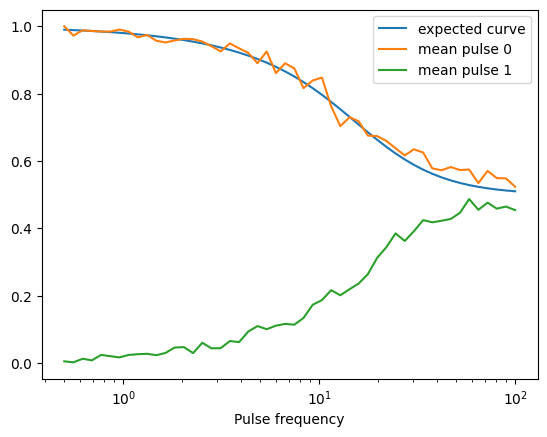

In [373]:
means_trials = np.zeros((num_freqs,2))
for k in range(num_freqs):
    means_trials[k,0]=np.sum(pulses[k]*observations[k])/np.sum(pulses[k])
    means_trials[k,1]=np.sum((1-pulses[k])*observations[k])/np.sum((1-pulses[k]))

r_test=1*r
alphas = 1/(1+np.exp(T_per_sides*r_test))
p_eval = (1-alphas)*(1-np.exp(-T_per_sides*r_test))/(r_test*T_per_sides)
plt.semilogx(freqs, 1-p_eval, label="expected curve")
plt.semilogx(freqs, means_trials,label=["mean pulse 0","mean pulse 1"])
plt.xlabel("Pulse frequency")
plt.legend()
pass

Simple Least squares fitting

rate 109.74987654930568 real rate:  100


Text(0, 0.5, 'Mean Squared Error')

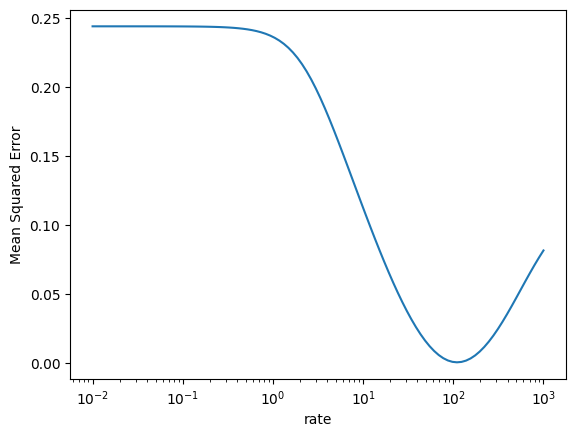

In [369]:
def error(means_trials, true_means, T_per_sides, r_test):
    alphas = 1/(1+np.exp(T_per_sides*r_test))
    p_eval = (1-alphas)*(1-np.exp(-T_per_sides*r_test))/(r_test*T_per_sides)
    exp_left = true_means[0]*p_eval+true_means[1]*(1-p_eval)
    exp_right = true_means[1]*p_eval+true_means[0]*(1-p_eval)
    return np.mean((means_trials[:,0] -exp_left)**2)+np.mean((means_trials[:,1] -exp_right)**2)
test_rates=np.logspace(-2,3,100)
errors=np.array([error(means_trials, means, T_per_sides, rate) for rate in test_rates])
print("rate", test_rates[np.argmin(errors)], "real rate: ", r)
plt.semilogx(test_rates, errors)
plt.xlabel("rate")
plt.ylabel("Mean Squared Error")

## Barrier Gate compensation

Assuming an exponential decay of rate with barrier values, take values at different gate offsets, i.e., different rates r, and then learn the parameters via a fit

<>:30: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_100349/464998388.py:30: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f'simulated measurement $r_0$={r_0}, $\gamma$={round(dr_0,2)}, '+"$r=r_0e^{dr v}$")


Text(0.5, 1.0, 'simulated measurement $r_0$=50, $\\gamma$=1.39, $r=r_0e^{dr v}$')

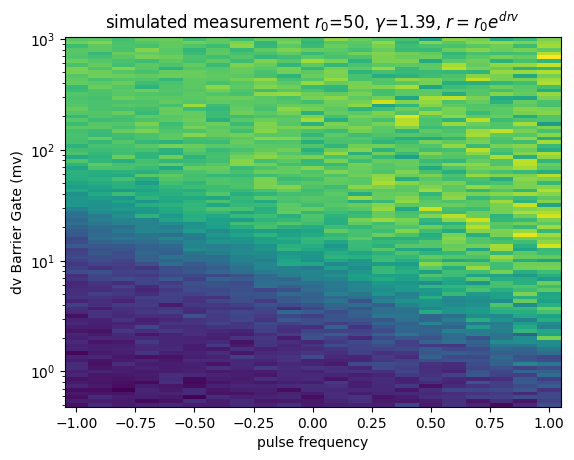

In [376]:
def sim_sweep(freqs, offsets_v, r_0, dr, num_meas, T,means, variances):
    rates = r_0*np.exp(-offsets_v * dr)
    means_trials=np.zeros((freqs.shape[0],offsets_v.shape[0],2))
    Ts_per_side = np.zeros((freqs.shape[0],offsets_v.shape[0]))
    for j,rate in enumerate(rates):
        for i,freq in enumerate(freqs):
            num_pulses = int(T*freq)
            meas_per_side = (num_meas//num_pulses)//2
            pulse,obs, T_per_side, state = simulation(freq,rate,num_pulses, meas_per_side,means, variances)
            means_trials[i,j,0]=np.sum(pulse*obs)/np.sum(pulse)
            means_trials[i,j,1]=np.sum((1-pulse)*obs)/np.sum((1-pulse))
            Ts_per_side[i,j] = T_per_side
    return means_trials, Ts_per_side

num_freqs = 100
num_offsets = 21
true_means = np.array([0.0,1.0])
variances = 10.0*np.ones(2)
T=10
r_0=50
dr_0=np.log(4)
offsets_v = np.linspace(-1,1,num_offsets)
freqs = np.logspace(np.log10(0.5),np.log10(1000),num_freqs)
means_trials, Ts_per_side = sim_sweep(freqs, offsets_v, r_0, dr_0, 50000, T,means, variances)

plt.pcolormesh(offsets_v,freqs,means_trials[:,:,1],shading="nearest")
plt.yscale("log")
plt.xlabel("pulse frequency")
plt.ylabel("dv Barrier Gate (mv)")
plt.title(f'simulated measurement $r_0$={r_0}, $\\gamma$={round(dr_0,2)}, '+"$r=r_0e^{dr v}$")

fit

In [377]:
def error(means_trials, true_means, T_per_sides, offsets_v, r,dr):
    r_test = r*np.exp(-offsets_v[None,:]*dr)
    alphas = 1/(1+np.exp(T_per_sides*r_test))
    p_eval = (1-alphas)*(1-np.exp(-T_per_sides*r_test))/(r_test*T_per_sides)
    exp_left = true_means[0]*p_eval+true_means[1]*(1-p_eval)
    exp_right = true_means[1]*p_eval+true_means[0]*(1-p_eval)
    return np.mean((means_trials[:,:,0] -exp_left)**2)+np.mean((means_trials[:,:,1] -exp_right)**2)
rates_test = np.logspace(-2,3,50)
dr_test = np.linspace(-1,2,100)

errors=np.zeros((100,50))
for i,r in enumerate(rates_test):
    for j,dr in enumerate(dr_test):
        errors[j,i] = error(means_trials, true_means, Ts_per_side, offsets_v, r,dr)


In [378]:
from scipy.optimize import minimize
f = lambda x: error(means_trials, true_means, Ts_per_side, offsets_v, x[0],x[1])
res=minimize(f,np.zeros(2),bounds=[(10,1000),(-10,10)])
print(res.x[0],res.x[1])

50.305249490051345 1.4249436721395705


In [379]:

idx = np.unravel_index(np.argmin(errors), errors.shape)
print(errors[idx],rates_test[idx[1]],dr_test[idx[0]])
print(error(means_trials, true_means, Ts_per_side, offsets_v, r_0,dr_0),r_0,dr_0)

0.00322788091253658 47.14866363457394 1.4242424242424243
0.0031655227967947648 50 1.3862943611198906


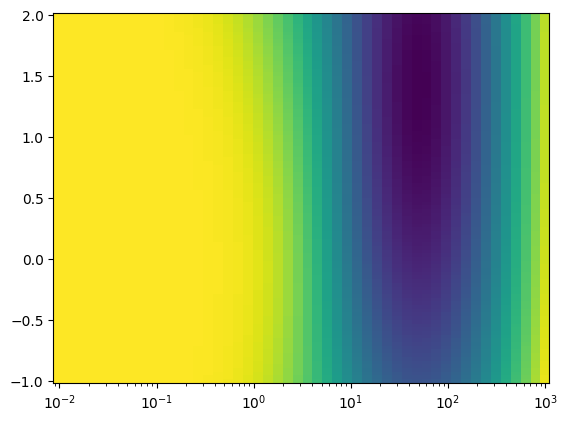

In [380]:
plt.pcolormesh(rates_test,dr_test,errors,shading="nearest")
plt.xscale("log")